In [100]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report


## Read Data

In [42]:
img_size=224 #ResNet50 224x224
batch_size=64

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0
)
train_generator = datagen_train.flow_from_directory(
    "C:/Users/fatem/Downloads/images_face/train",
    target_size=(img_size, img_size),
    color_mode="rgb",  # Use RGB for ResNet50
    batch_size=batch_size,
    class_mode="sparse",  # Use sparse for integer-encoded labels
    shuffle=True
)

datagen_test = ImageDataGenerator(
    rescale=1.0/255.0
)
test_generator = datagen_test.flow_from_directory(
    "C:/Users/fatem/Downloads/images_face/test",
    target_size=(img_size, img_size),
    color_mode="rgb", 
    batch_size=batch_size,
    class_mode="sparse",  
    shuffle=True
)
x_test, y_test = next(test_generator)
x_train, y_train = next(train_generator)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [43]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (64, 224, 224, 3)
y_train shape: (64,)
x_test shape: (64, 224, 224, 3)
y_test shape: (64,)


# Transfer Learning

In [44]:
base_model=ResNet50(weights="imagenet",include_top=False,input_shape=(224,224,3))

# Add layers
x = base_model.output
x = Flatten()(x)
x = Dense(256,activation="relu")(x)
x = Dense(64,activation="relu")(x)
x = Dense(32,activation="relu")(x)
x = Dense(256,activation="relu")(x)
output = Dense(7,activation="softmax")(x)

# final model
model=Model(inputs=base_model.input,outputs=output)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable=False

# Unfreez the base model 
for layer in base_model.layers[-10:]:
    layer.trainable=True

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Callbacks

In [47]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,               
    patience=5,               
    verbose=1,                 
    min_delta=0.02, 
)

checkpoint_callback_val = tf.keras.callbacks.ModelCheckpoint(
    'best_model_val_CNN.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_callback_train = tf.keras.callbacks.ModelCheckpoint(
    'best_model_train_CNN.keras',
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=250,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint_callback_val,checkpoint_callback_train,reduce_lr],
    verbose=1
)

Epoch 1/250
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4391 - loss: 1.4510
Epoch 1: val_accuracy improved from -inf to 0.38714, saving model to best_model_val_CNN.keras

Epoch 1: accuracy improved from -inf to 0.43693, saving model to best_model_train_CNN.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 3311s 7s/step - accuracy: 0.4391 - loss: 1.4510 - val_accuracy: 0.3871 - val_loss: 1.7059 - learning_rate: 5.0000e-04
Epoch 2/250
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:42:36 14s/step - accuracy: 0.3906 - loss: 1.5180
Epoch 2: val_accuracy did not improve from 0.38714

Epoch 2: accuracy did not improve from 0.43693
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.3906 - loss: 1.5180 - val_accuracy: 0.3000 - val_loss: 1.9433 - learning_rate: 5.0000e-04
Epoch 3/250
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4428 - loss: 1.4448
Epoch 3: val_accuracy did not improve from 0.38714

Epoch 3: accuracy improved from 0.43693 to 0.44140, saving model to best_model_train_CNN.keras
448/448 ━━

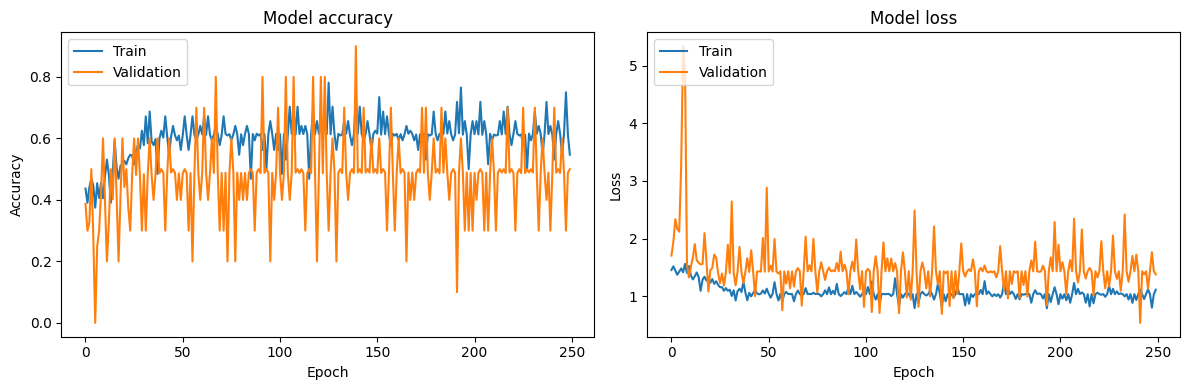

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Using the best model

In [61]:

best_model = load_model('best_model_val_CNN.keras')

x = best_model.output  # Get the output of the last layer of the loaded model
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output = Dense(7, activation="softmax")(x)  

model = Model(inputs=best_model.input, outputs=output)


for layer in best_model.layers:
    layer.trainable = False
for layer in best_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [63]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint_callback_val,checkpoint_callback_train,reduce_lr],
    verbose=1
)

Epoch 1/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3763 - loss: 1.6113
Epoch 1: val_accuracy did not improve from 0.90000

Epoch 1: accuracy did not improve from 0.78125
448/448 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.3763 - loss: 1.6111 - val_accuracy: 0.3965 - val_loss: 1.5019 - learning_rate: 0.0010
Epoch 2/100
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8:15 1s/step - accuracy: 0.5000 - loss: 1.4598

c:\Users\fatem\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy did not improve from 0.90000

Epoch 2: accuracy did not improve from 0.78125
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.5000 - loss: 1.4598 - val_accuracy: 0.3000 - val_loss: 1.9060 - learning_rate: 0.0010
Epoch 3/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4464 - loss: 1.4089
Epoch 3: val_accuracy did not improve from 0.90000

Epoch 3: accuracy did not improve from 0.78125
448/448 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.4464 - loss: 1.4088 - val_accuracy: 0.4580 - val_loss: 1.4437 - learning_rate: 0.0010
Epoch 4/100
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8:15 1s/step - accuracy: 0.5469 - loss: 1.5025
Epoch 4: val_accuracy did not improve from 0.90000

Epoch 4: accuracy did not improve from 0.78125
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.5469 - loss: 1.5025 - val_accuracy: 0.6000 - val_loss: 1.3534 - learning_rate: 0.0010
Epoch 5/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5104 - loss: 1.3025
Epoch 5: val_a

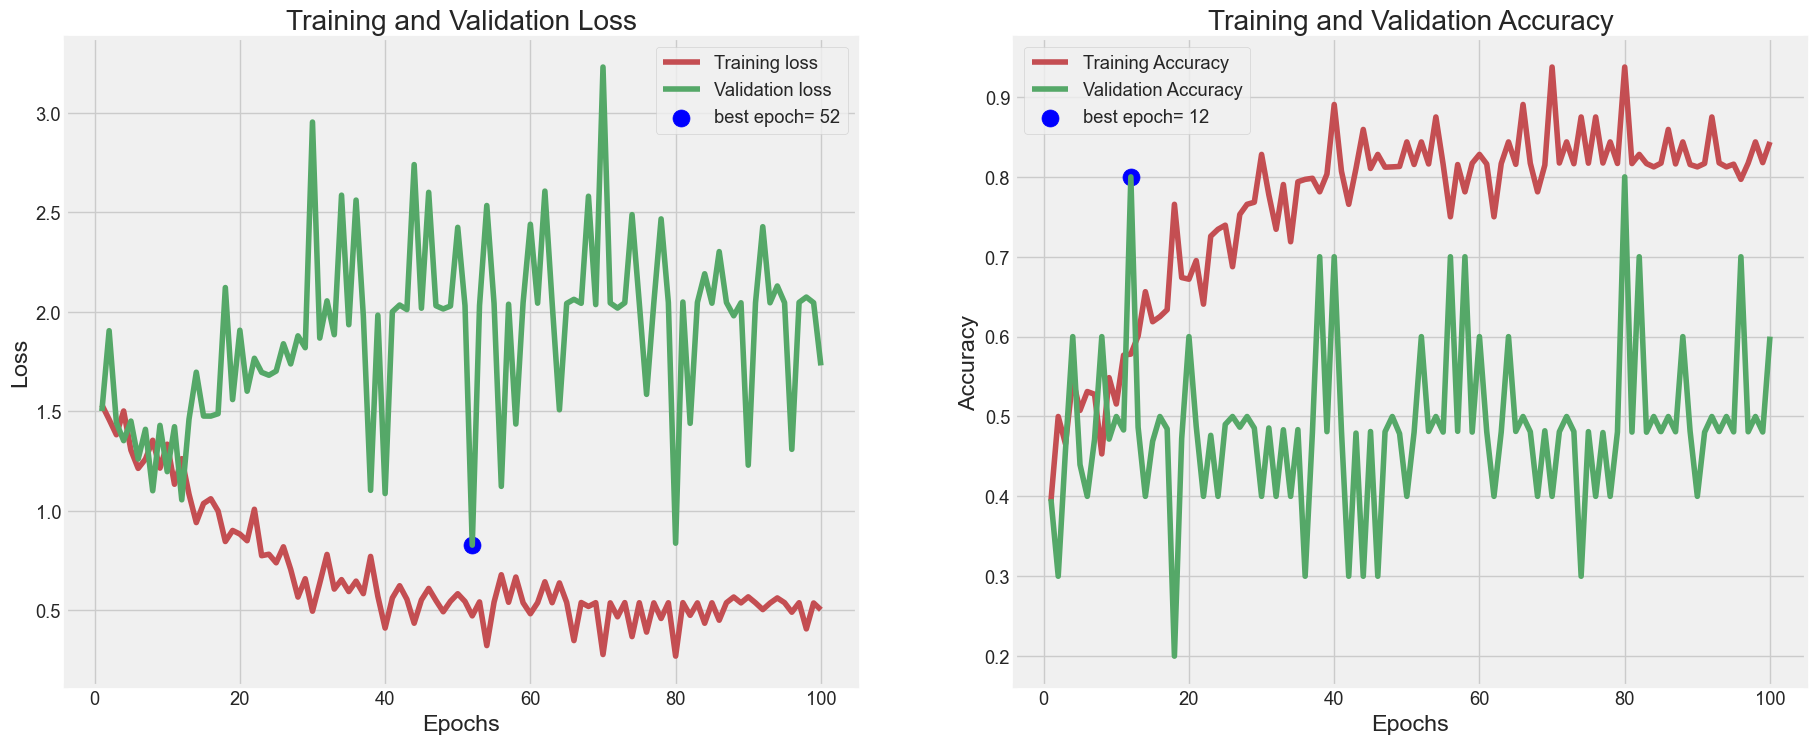

In [166]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step


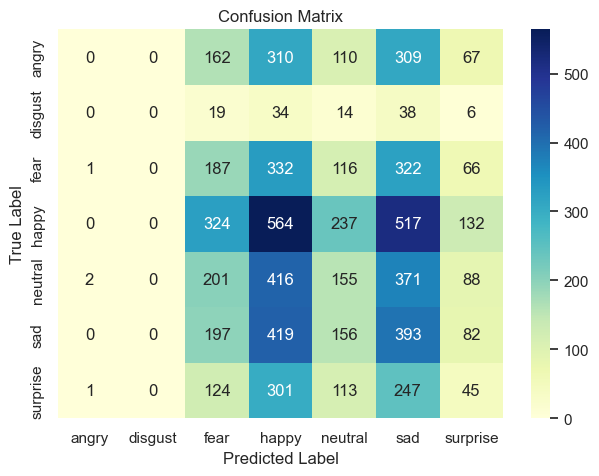

In [168]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = test_generator.classes
validation_pred_probs = model.predict(test_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


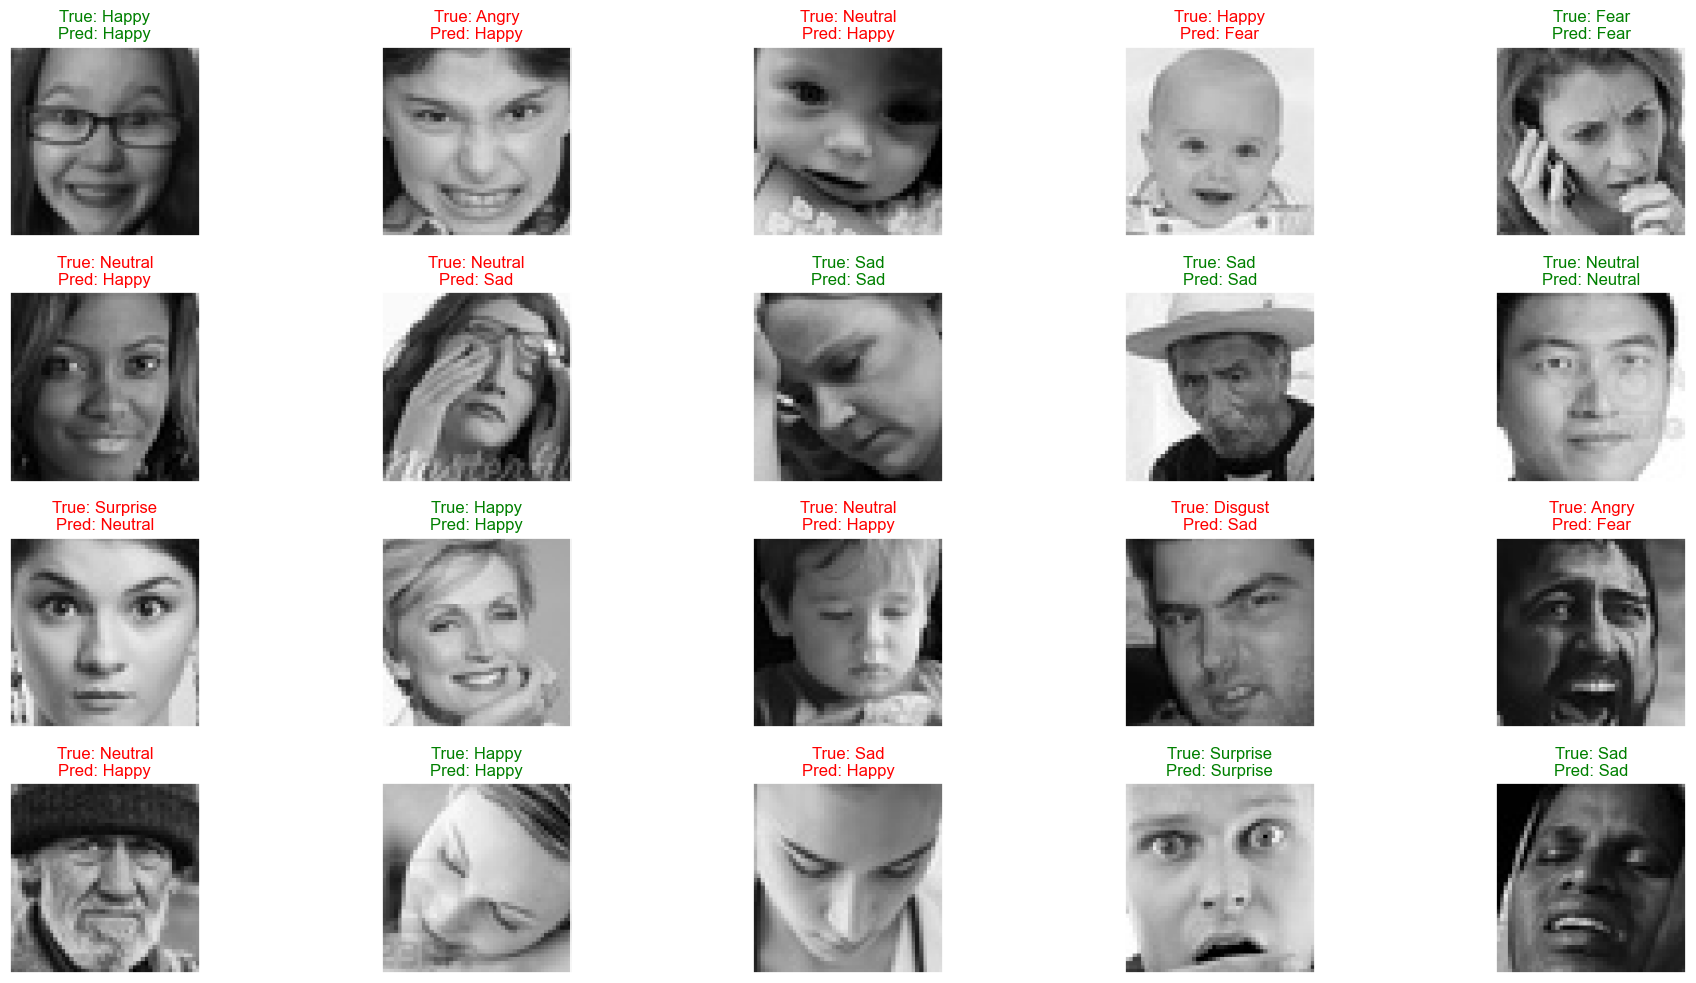

In [173]:
# Number of images to display
num_images =20
# Get a batch from the test generator
test_images, test_labels = next(test_generator)

# Make predictions on the batch
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1).astype(int)

# Convert one-hot encoded test_labels to class indices if needed
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    true_labels = np.argmax(test_labels, axis=1).astype(int)  # Convert one-hot to class indices and ensure integer type
else:
    true_labels = test_labels.astype(int)  # Already integer class indices

# Emotion classes
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Ensure that we don't try to access more images than we have
num_images = min(num_images, len(test_images))

# Plot the images with true and predicted labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_images:  # Ensure we do not exceed the number of available images
        img = test_images[i]
        true_label = Emotion_Classes[int(true_labels[i])]  # Convert index to integer
        pred_label = Emotion_Classes[int(predicted_labels[i])]  # Convert index to integer

        # Display the image
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')

plt.tight_layout()
plt.show()
